In [15]:
import numpy as np
import matplotlib.pyplot as plt
import bnk

# Structure

## Atom Structure

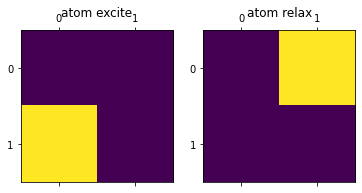

In [16]:
atom = bnk.HSpace(2, name='atom')

atom_excite = atom.eigenstate(1) @ atom.eigenstate(0).ct
atom_relax = atom_excite.ct


plt.subplot(1, 2, 1)
plt.matshow(atom_excite.flattened_values, 0)
plt.title("atom excite")

plt.subplot(1, 2, 2)
plt.matshow(atom_relax.flattened_values, 0)
plt.title("atom relax")

plt.show()

## Field Structure

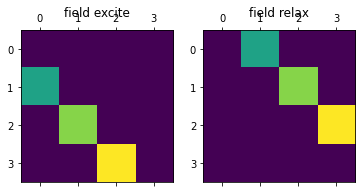

In [17]:
field = bnk.HSpace(4, name='field')

field_excite = 0
for i in range(1, field.n):
    field_excite_i = field.eigenstate(i) @ field.eigenstate(i - 1).ct
    field_excite += np.sqrt(i) * field_excite_i
field_relax = field_excite.ct


plt.subplot(1, 2, 1)
plt.matshow(field_excite.flattened_values, 0)
plt.title("field excite")

plt.subplot(1, 2, 2)
plt.matshow(field_relax.flattened_values, 0)
plt.title("field relax")

plt.show()

# Evolution

## Hamiltonian

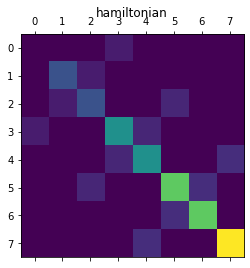

In [18]:
hb = 1
w = 1
g = 0.3

interaction = g * (0
    + atom_relax @ field_excite
    + atom_excite @ field_relax
    + atom_excite @ field_excite
    + atom_relax @ field_relax
)

energy = hb * w * (0
    + atom_excite @ atom_relax
    + field_excite @ field_relax
)

hamiltonian = energy + interaction


plt.matshow(hamiltonian.flattened_values)
plt.title("hamiltonian")
plt.show()

# Iteration

## Initial $\psi$

In [19]:
psi0 = atom.eigenstate(0) @ field.eigenstate(1)

print('psi0')
print(psi0.values)

psi0
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]]


## Configurations

In [20]:
dt = 1e-5
mt = 50

dlt = mt/200

## Iteration

In [21]:
logs_t = []
logs_probs = []
logs_angle = []

def log_func(t, psi):
    probs = np.conj(psi.values) * psi.values
    angle = np.angle(psi.values) / np.pi
    
    logs_t.append(t)
    logs_probs.append(probs)
    logs_angle.append(angle)

In [22]:
%%time

bnk.schrodinger_evolve(
    0.0, psi0, hamiltonian, hb,
    mt, dt, dlt, log_func)

100%|██████████| 50.0/50 [00:28<00:00,  1.74it/s] 


Wall time: 28.8 s


(50.0, <bnk.tensor.QTensor at 0x26ea8574208>)

C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


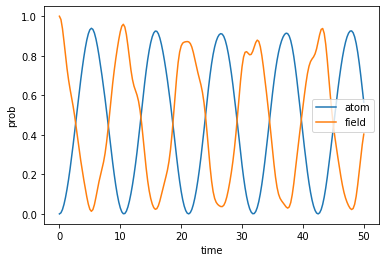

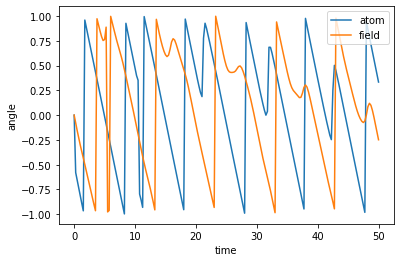

In [23]:
def plot_logs(logs_t, logs_probs, logs_angle):
    logs_t = np.asarray(logs_t)
    logs_probs = np.asarray(logs_probs)
    logs_angle = np.asarray(logs_angle)
    
    plt.figure()
    plt.plot(logs_t, logs_probs[:,1,0], label='atom')
    plt.plot(logs_t, logs_probs[:,0,1], label='field')
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("prob")
    plt.show()

    plt.figure()
    plt.plot(logs_t, logs_angle[:,1,0], label='atom')
    plt.plot(logs_t, logs_angle[:,0,1], label='field')
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("angle")
    plt.show()

plot_logs(logs_t, logs_probs, logs_angle)

# Reduction

In [24]:
reduced_space = bnk.ReducedHSpace.from_seed(
    [psi0],[hamiltonian],'reduced_system')

print([dim.name for dim in reduced_space.org_eigenstates[0].dims])
for i, org_eigenstate in enumerate(reduced_space.org_eigenstates):
    code = list(np.transpose(np.where(org_eigenstate.values))[0])
    print(i, code)

['atom', 'field']
0 [0, 1]
1 [0, 3]
2 [1, 0]
3 [1, 2]


## Evolution (reduced)

reduced psi0
[1. 0. 0. 0.]


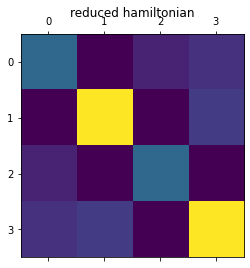

In [25]:
reduced_psi0 = reduced_space.reduce(psi0)
reduced_hamiltonian = reduced_space.reduce(hamiltonian)

print('reduced psi0')
print(reduced_psi0.values)

plt.matshow(reduced_hamiltonian.flattened_values)
plt.title("reduced hamiltonian")
plt.show()

## Iteration (reduced)

In [26]:
logs_t = []
logs_probs = []
logs_angle = []

def log_func_reduced(t, psi_reduced):
    log_func(t, reduced_space.inflate(psi_reduced))

In [27]:
%%time

bnk.schrodinger_evolve(
    0.0, reduced_psi0, reduced_hamiltonian, hb,
    mt, dt, dlt, log_func_reduced)

100%|██████████| 50.0/50 [00:27<00:00,  1.82it/s] 


Wall time: 27.5 s


(50.0, <bnk.tensor.QTensor at 0x26ea84e3b48>)

C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


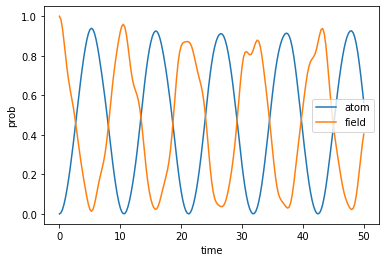

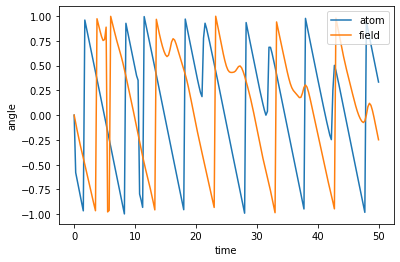

In [28]:
plot_logs(logs_t, logs_probs, logs_angle)